In [1]:
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from celluloid import Camera as Cam

In [2]:
# Constants
ACTIVE_LEARNING_BATCH_SIZE = 50

In [99]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_classification(ax, clf, X, Y, X_all):
    """
    Plot the results of a classifier
    """
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X_all[:,0], X_all[:,1])

    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

def classify(X, Y):
    """
    Fit a linear SVM to the data, returning the classifier.
    """
    clf = svm.LinearSVC()
    clf.fit(X, Y)
    return clf

def active_split(X, Y):
    """
    Split data into three sets:
    * Labeled training set (0.1)
    * Unlabeled training set, to be queried (0.4)
    * Labeled test set (0.5)
    """

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)
    X_labelled, X_unlabelled, Y_labelled, Y_oracle = train_test_split(X_train, Y_train, test_size=0.9)

    return X_labelled, X_unlabelled, Y_labelled, Y_oracle, X_test, Y_test

def query(n=ACTIVE_LEARNING_BATCH_SIZE):
    """
    Active learning query (simple confidence measure)
    """
    return np.argsort(np.abs(clf.decision_function(X_current_unlabelled)))[:n]



In [100]:
class ActiveClassifier():
    def __init__(self, X_labelled, X_unlabelled, Y_labelled, Y_oracle, X_test, Y_test):
        self.clf = svm.LinearSVC()
        self.X_labelled = X_labelled
        self.X_unlabelled = X_unlabelled
        self.Y_labelled = Y_labelled
        self.Y_oracle = Y_oracle
        self.X_test = X_test
        self.Y_test = Y_test
        self.clf.fit(self.X_labelled, self.Y_labelled)

    def fit(self, n=None):
        if len(self.X_unlabelled) == 0:
            raise Exception("fit done")
        if n is None:
            X_step = np.vstack((X_labelled, X_unlabelled))
            Y_step = np.append(Y_labelled, Y_oracle)
            self.X_labelled = np.vstack((self.X_labelled, self.self.X_unlabelled))
            self.Y_labelled = np.append(self.Y_labelled, self.Y_oracle)
            self.X_unlabelled = np.array()
            self.Y_oracle = np.array()
        else:
            try:
                step_indicies = np.argsort(np.abs(self.clf.decision_function(self.X_unlabelled)))[:n]
            except IndexError:
                print("WARNING: Could not fit n points")
                step_indicies = np.argsort(np.abs(self.clf.decision_function(self.X_unlabelled)))
            self.X_labelled = np.vstack((self.X_labelled, self.X_unlabelled[step_indicies]))
            self.Y_labelled = np.append(self.Y_labelled, self.Y_oracle[step_indicies])
            self.X_unlabelled = np.delete(self.X_unlabelled, step_indicies, axis=0)
            self.Y_oracle = np.delete(self.Y_oracle, step_indicies)

        self.clf = svm.LinearSVC()
        self.clf.fit(self.X_labelled, self.Y_labelled)

    def is_fit_done(self):
        return len(self.X_unlabelled) == 0

    def n_to_fit(self):
        return len(self.X_unlabelled)

    def plot(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1,1, figsize=(6,6))
        plot_classification(ax, self.clf, self.X_labelled, self.Y_labelled, np.vstack((self.X_labelled, self.X_unlabelled)))
        ax.scatter(self.X_unlabelled[:,0], self.X_unlabelled[:,1], c='black', s=5)

    def accuracy(self):
        return accuracy_score(self.Y_test, self.clf.predict(self.X_test))


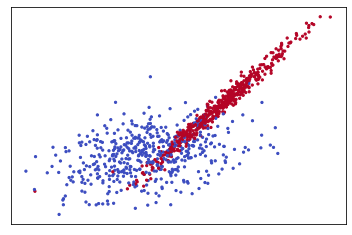

In [77]:
X, Y = datasets.make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1)
plt.scatter(X[:,0], X[:,1], c=Y, s=5, cmap=plt.cm.coolwarm)
plt.xticks(())
plt.yticks(());

In [95]:
X_labelled, X_unlabelled, Y_labelled, Y_oracle, X_test, Y_test = active_split(X, Y)

In [105]:
active = ActiveClassifier(X_labelled, X_unlabelled, Y_labelled, Y_oracle, X_test, Y_test)

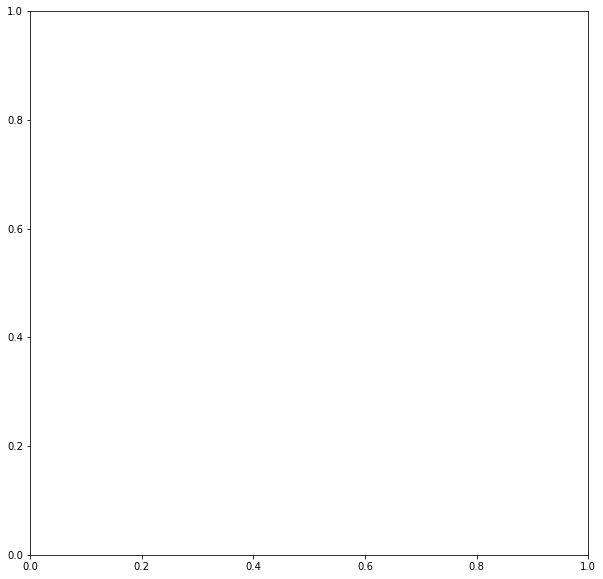

In [106]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
cam = Cam(fig)

In [107]:
while not active.is_fit_done():
    active.plot(ax=ax)
    cam.snap()
    active.fit(n=50)

In [108]:
active.plot(ax=ax)
cam.snap();

In [109]:
cam.animate().save("animation.gif")